In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir  = '/content/drive/MyDrive/FYP/Dataset/Our_Dataset'

classes = os.listdir(data_dir)
print(classes)


['Bio', 'Non_Bio']


In [ ]:
import os

# Define the path to the folder containing the images
folder_path = '/content/drive/MyDrive/FYP/Dataset/Our_Dataset/Non_Bio'

# Initialize a variable to count the number of images
num_images = 0
filenames = []
# Loop through each file in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image file
    delimiter = "."
    filename_new = delimiter.join(filename.split(delimiter)[1:])
    filenames.append(filename_new)
    # if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
    #     # Increment the count
    num_images += 1
filenames = set(filenames)
print(filenames)
print("Number of images in the folder:", num_images)

{'jpg', 'jpeg'}
Number of images in the folder: 1190


In [ ]:
len(data_dir)

46

In [ ]:
def filter_augmented_images(filename):
    return '_aug_' not in filename


In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: Bio (Class No: 0)


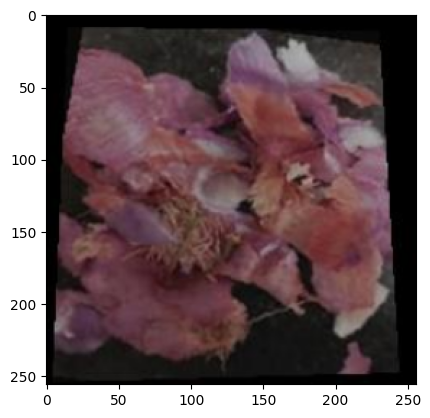

In [ ]:
img, label = dataset[100]
show_sample(img, label)


In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
len(dataset)

2372

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset,[int(0.8*len(dataset)), int(0.1*len(dataset)), int(0.1*len(dataset))+1])
len(train_ds), len(val_ds), len(test_ds)


(1897, 237, 238)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32


In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


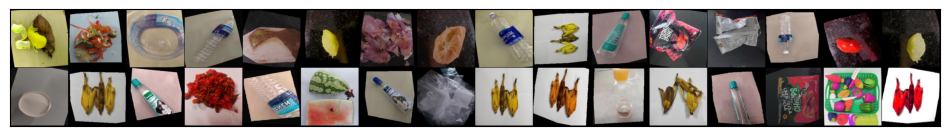

In [ ]:
show_batch(train_dl)


MODEL


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.4MB/s]


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

TRAINING

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
model = to_device(ResNet(), device)


In [ ]:
evaluate(model, val_dl)


{'val_loss': 0.7009221315383911, 'val_acc': 0.4230034649372101}

In [ ]:
# num_epochs = 8
num_epochs = 5
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.4038, val_loss: 0.3308, val_acc: 0.9961
Epoch 2: train_loss: 0.3196, val_loss: 0.3158, val_acc: 1.0000
Epoch 3: train_loss: 0.3160, val_loss: 0.3158, val_acc: 1.0000
Epoch 4: train_loss: 0.3146, val_loss: 0.3160, val_acc: 0.9961
Epoch 5: train_loss: 0.3145, val_loss: 0.3155, val_acc: 0.9961


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

NameError: name 'predict_image' is not defined

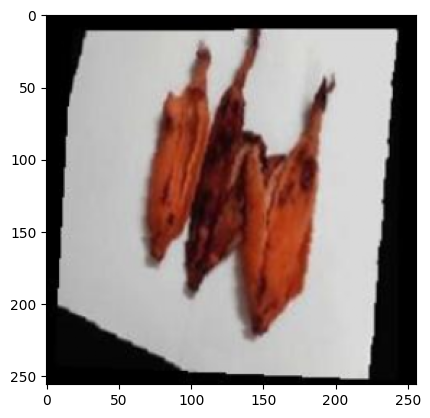

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))


In [ ]:
img, label = test_ds[9]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[5]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))



TESTING FROM EXTRENAL SOURCES

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FYP/new_data_model_latest.pth')


In [ ]:
state_dict = torch.load('/content/drive/MyDrive/FYP/new_data_model_1.pth')


In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()
model.load_state_dict(state_dict)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
from torchvision.models import resnet50


In [ ]:
model = resnet50(pretrained = False)
num_ftrs = self.network.fc.in_features
self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model.load_state_dict(state_dict)


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "network.conv1.weight", "network.bn1.weight", "network.bn1.bias", "network.bn1.running_mean", "network.bn1.running_var", "network.bn1.num_batches_tracked", "network.layer1.0.conv1.weight", "network.layer1.0.bn1.weight", "network.layer1.0.bn1.bias", "network.layer1.0.bn1.running_mean", "network.layer1.0.bn1.running_var", "network.layer1.0.bn1.num_batches_tracked", "network.layer1.0.conv2.weight", "network.layer1.0.bn2.weight", "network.layer1.0.bn2.bias", "network.layer1.0.bn2.running_mean", "network.layer1.0.bn2.running_var", "network.layer1.0.bn2.num_batches_tracked", "network.layer1.0.conv3.weight", "network.layer1.0.bn3.weight", "network.layer1.0.bn3.bias", "network.layer1.0.bn3.running_mean", "network.layer1.0.bn3.running_var", "network.layer1.0.bn3.num_batches_tracked", "network.layer1.0.downsample.0.weight", "network.layer1.0.downsample.1.weight", "network.layer1.0.downsample.1.bias", "network.layer1.0.downsample.1.running_mean", "network.layer1.0.downsample.1.running_var", "network.layer1.0.downsample.1.num_batches_tracked", "network.layer1.1.conv1.weight", "network.layer1.1.bn1.weight", "network.layer1.1.bn1.bias", "network.layer1.1.bn1.running_mean", "network.layer1.1.bn1.running_var", "network.layer1.1.bn1.num_batches_tracked", "network.layer1.1.conv2.weight", "network.layer1.1.bn2.weight", "network.layer1.1.bn2.bias", "network.layer1.1.bn2.running_mean", "network.layer1.1.bn2.running_var", "network.layer1.1.bn2.num_batches_tracked", "network.layer1.1.conv3.weight", "network.layer1.1.bn3.weight", "network.layer1.1.bn3.bias", "network.layer1.1.bn3.running_mean", "network.layer1.1.bn3.running_var", "network.layer1.1.bn3.num_batches_tracked", "network.layer1.2.conv1.weight", "network.layer1.2.bn1.weight", "network.layer1.2.bn1.bias", "network.layer1.2.bn1.running_mean", "network.layer1.2.bn1.running_var", "network.layer1.2.bn1.num_batches_tracked", "network.layer1.2.conv2.weight", "network.layer1.2.bn2.weight", "network.layer1.2.bn2.bias", "network.layer1.2.bn2.running_mean", "network.layer1.2.bn2.running_var", "network.layer1.2.bn2.num_batches_tracked", "network.layer1.2.conv3.weight", "network.layer1.2.bn3.weight", "network.layer1.2.bn3.bias", "network.layer1.2.bn3.running_mean", "network.layer1.2.bn3.running_var", "network.layer1.2.bn3.num_batches_tracked", "network.layer2.0.conv1.weight", "network.layer2.0.bn1.weight", "network.layer2.0.bn1.bias", "network.layer2.0.bn1.running_mean", "network.layer2.0.bn1.running_var", "network.layer2.0.bn1.num_batches_tracked", "network.layer2.0.conv2.weight", "network.layer2.0.bn2.weight", "network.layer2.0.bn2.bias", "network.layer2.0.bn2.running_mean", "network.layer2.0.bn2.running_var", "network.layer2.0.bn2.num_batches_tracked", "network.layer2.0.conv3.weight", "network.layer2.0.bn3.weight", "network.layer2.0.bn3.bias", "network.layer2.0.bn3.running_mean", "network.layer2.0.bn3.running_var", "network.layer2.0.bn3.num_batches_tracked", "network.layer2.0.downsample.0.weight", "network.layer2.0.downsample.1.weight", "network.layer2.0.downsample.1.bias", "network.layer2.0.downsample.1.running_mean", "network.layer2.0.downsample.1.running_var", "network.layer2.0.downsample.1.num_batches_tracked", "network.layer2.1.conv1.weight", "network.layer2.1.bn1.weight", "network.layer2.1.bn1.bias", "network.layer2.1.bn1.running_mean", "network.layer2.1.bn1.running_var", "network.layer2.1.bn1.num_batches_tracked", "network.layer2.1.conv2.weight", "network.layer2.1.bn2.weight", "network.layer2.1.bn2.bias", "network.layer2.1.bn2.running_mean", "network.layer2.1.bn2.running_var", "network.layer2.1.bn2.num_batches_tracked", "network.layer2.1.conv3.weight", "network.layer2.1.bn3.weight", "network.layer2.1.bn3.bias", "network.layer2.1.bn3.running_mean", "network.layer2.1.bn3.running_var", "network.layer2.1.bn3.num_batches_tracked", "network.layer2.2.conv1.weight", "network.layer2.2.bn1.weight", "network.layer2.2.bn1.bias", "network.layer2.2.bn1.running_mean", "network.layer2.2.bn1.running_var", "network.layer2.2.bn1.num_batches_tracked", "network.layer2.2.conv2.weight", "network.layer2.2.bn2.weight", "network.layer2.2.bn2.bias", "network.layer2.2.bn2.running_mean", "network.layer2.2.bn2.running_var", "network.layer2.2.bn2.num_batches_tracked", "network.layer2.2.conv3.weight", "network.layer2.2.bn3.weight", "network.layer2.2.bn3.bias", "network.layer2.2.bn3.running_mean", "network.layer2.2.bn3.running_var", "network.layer2.2.bn3.num_batches_tracked", "network.layer2.3.conv1.weight", "network.layer2.3.bn1.weight", "network.layer2.3.bn1.bias", "network.layer2.3.bn1.running_mean", "network.layer2.3.bn1.running_var", "network.layer2.3.bn1.num_batches_tracked", "network.layer2.3.conv2.weight", "network.layer2.3.bn2.weight", "network.layer2.3.bn2.bias", "network.layer2.3.bn2.running_mean", "network.layer2.3.bn2.running_var", "network.layer2.3.bn2.num_batches_tracked", "network.layer2.3.conv3.weight", "network.layer2.3.bn3.weight", "network.layer2.3.bn3.bias", "network.layer2.3.bn3.running_mean", "network.layer2.3.bn3.running_var", "network.layer2.3.bn3.num_batches_tracked", "network.layer3.0.conv1.weight", "network.layer3.0.bn1.weight", "network.layer3.0.bn1.bias", "network.layer3.0.bn1.running_mean", "network.layer3.0.bn1.running_var", "network.layer3.0.bn1.num_batches_tracked", "network.layer3.0.conv2.weight", "network.layer3.0.bn2.weight", "network.layer3.0.bn2.bias", "network.layer3.0.bn2.running_mean", "network.layer3.0.bn2.running_var", "network.layer3.0.bn2.num_batches_tracked", "network.layer3.0.conv3.weight", "network.layer3.0.bn3.weight", "network.layer3.0.bn3.bias", "network.layer3.0.bn3.running_mean", "network.layer3.0.bn3.running_var", "network.layer3.0.bn3.num_batches_tracked", "network.layer3.0.downsample.0.weight", "network.layer3.0.downsample.1.weight", "network.layer3.0.downsample.1.bias", "network.layer3.0.downsample.1.running_mean", "network.layer3.0.downsample.1.running_var", "network.layer3.0.downsample.1.num_batches_tracked", "network.layer3.1.conv1.weight", "network.layer3.1.bn1.weight", "network.layer3.1.bn1.bias", "network.layer3.1.bn1.running_mean", "network.layer3.1.bn1.running_var", "network.layer3.1.bn1.num_batches_tracked", "network.layer3.1.conv2.weight", "network.layer3.1.bn2.weight", "network.layer3.1.bn2.bias", "network.layer3.1.bn2.running_mean", "network.layer3.1.bn2.running_var", "network.layer3.1.bn2.num_batches_tracked", "network.layer3.1.conv3.weight", "network.layer3.1.bn3.weight", "network.layer3.1.bn3.bias", "network.layer3.1.bn3.running_mean", "network.layer3.1.bn3.running_var", "network.layer3.1.bn3.num_batches_tracked", "network.layer3.2.conv1.weight", "network.layer3.2.bn1.weight", "network.layer3.2.bn1.bias", "network.layer3.2.bn1.running_mean", "network.layer3.2.bn1.running_var", "network.layer3.2.bn1.num_batches_tracked", "network.layer3.2.conv2.weight", "network.layer3.2.bn2.weight", "network.layer3.2.bn2.bias", "network.layer3.2.bn2.running_mean", "network.layer3.2.bn2.running_var", "network.layer3.2.bn2.num_batches_tracked", "network.layer3.2.conv3.weight", "network.layer3.2.bn3.weight", "network.layer3.2.bn3.bias", "network.layer3.2.bn3.running_mean", "network.layer3.2.bn3.running_var", "network.layer3.2.bn3.num_batches_tracked", "network.layer3.3.conv1.weight", "network.layer3.3.bn1.weight", "network.layer3.3.bn1.bias", "network.layer3.3.bn1.running_mean", "network.layer3.3.bn1.running_var", "network.layer3.3.bn1.num_batches_tracked", "network.layer3.3.conv2.weight", "network.layer3.3.bn2.weight", "network.layer3.3.bn2.bias", "network.layer3.3.bn2.running_mean", "network.layer3.3.bn2.running_var", "network.layer3.3.bn2.num_batches_tracked", "network.layer3.3.conv3.weight", "network.layer3.3.bn3.weight", "network.layer3.3.bn3.bias", "network.layer3.3.bn3.running_mean", "network.layer3.3.bn3.running_var", "network.layer3.3.bn3.num_batches_tracked", "network.layer3.4.conv1.weight", "network.layer3.4.bn1.weight", "network.layer3.4.bn1.bias", "network.layer3.4.bn1.running_mean", "network.layer3.4.bn1.running_var", "network.layer3.4.bn1.num_batches_tracked", "network.layer3.4.conv2.weight", "network.layer3.4.bn2.weight", "network.layer3.4.bn2.bias", "network.layer3.4.bn2.running_mean", "network.layer3.4.bn2.running_var", "network.layer3.4.bn2.num_batches_tracked", "network.layer3.4.conv3.weight", "network.layer3.4.bn3.weight", "network.layer3.4.bn3.bias", "network.layer3.4.bn3.running_mean", "network.layer3.4.bn3.running_var", "network.layer3.4.bn3.num_batches_tracked", "network.layer3.5.conv1.weight", "network.layer3.5.bn1.weight", "network.layer3.5.bn1.bias", "network.layer3.5.bn1.running_mean", "network.layer3.5.bn1.running_var", "network.layer3.5.bn1.num_batches_tracked", "network.layer3.5.conv2.weight", "network.layer3.5.bn2.weight", "network.layer3.5.bn2.bias", "network.layer3.5.bn2.running_mean", "network.layer3.5.bn2.running_var", "network.layer3.5.bn2.num_batches_tracked", "network.layer3.5.conv3.weight", "network.layer3.5.bn3.weight", "network.layer3.5.bn3.bias", "network.layer3.5.bn3.running_mean", "network.layer3.5.bn3.running_var", "network.layer3.5.bn3.num_batches_tracked", "network.layer4.0.conv1.weight", "network.layer4.0.bn1.weight", "network.layer4.0.bn1.bias", "network.layer4.0.bn1.running_mean", "network.layer4.0.bn1.running_var", "network.layer4.0.bn1.num_batches_tracked", "network.layer4.0.conv2.weight", "network.layer4.0.bn2.weight", "network.layer4.0.bn2.bias", "network.layer4.0.bn2.running_mean", "network.layer4.0.bn2.running_var", "network.layer4.0.bn2.num_batches_tracked", "network.layer4.0.conv3.weight", "network.layer4.0.bn3.weight", "network.layer4.0.bn3.bias", "network.layer4.0.bn3.running_mean", "network.layer4.0.bn3.running_var", "network.layer4.0.bn3.num_batches_tracked", "network.layer4.0.downsample.0.weight", "network.layer4.0.downsample.1.weight", "network.layer4.0.downsample.1.bias", "network.layer4.0.downsample.1.running_mean", "network.layer4.0.downsample.1.running_var", "network.layer4.0.downsample.1.num_batches_tracked", "network.layer4.1.conv1.weight", "network.layer4.1.bn1.weight", "network.layer4.1.bn1.bias", "network.layer4.1.bn1.running_mean", "network.layer4.1.bn1.running_var", "network.layer4.1.bn1.num_batches_tracked", "network.layer4.1.conv2.weight", "network.layer4.1.bn2.weight", "network.layer4.1.bn2.bias", "network.layer4.1.bn2.running_mean", "network.layer4.1.bn2.running_var", "network.layer4.1.bn2.num_batches_tracked", "network.layer4.1.conv3.weight", "network.layer4.1.bn3.weight", "network.layer4.1.bn3.bias", "network.layer4.1.bn3.running_mean", "network.layer4.1.bn3.running_var", "network.layer4.1.bn3.num_batches_tracked", "network.layer4.2.conv1.weight", "network.layer4.2.bn1.weight", "network.layer4.2.bn1.bias", "network.layer4.2.bn1.running_mean", "network.layer4.2.bn1.running_var", "network.layer4.2.bn1.num_batches_tracked", "network.layer4.2.conv2.weight", "network.layer4.2.bn2.weight", "network.layer4.2.bn2.bias", "network.layer4.2.bn2.running_mean", "network.layer4.2.bn2.running_var", "network.layer4.2.bn2.num_batches_tracked", "network.layer4.2.conv3.weight", "network.layer4.2.bn3.weight", "network.layer4.2.bn3.bias", "network.layer4.2.bn3.running_mean", "network.layer4.2.bn3.running_var", "network.layer4.2.bn3.num_batches_tracked", "network.fc.weight", "network.fc.bias". 

In [ ]:
model.eval()


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# Assuming model is your trained ResNet model


# Path to your image file
image_path = '/content/drive/MyDrive/bio_test.png'
# Load the image
image = Image.open(image_path)

# Convert the image to a format compatible with PyTorch models (e.g., RGB)
image = image.convert('RGB')

transform = transforms.Compose([
    transforms.ToTensor(),
])

image_tensor = transform(image)

# Add a batch dimension if necessary
if len(image_tensor.shape) == 3:
    image_tensor = image_tensor.unsqueeze(0)

# Move the image tensor to the same device as the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = image_tensor.to(device)

# Move the model to the same device
model = model.to(device)

# Perform inference on the image tensor
with torch.no_grad():
    output = model(image_tensor)

# Optionally, convert the output to probabilities using softmax
probabilities = torch.softmax(output, dim=1)

# Print or use the output probabilities as needed
print(probabilities)


tensor([[0.7259, 0.2741]], device='cuda:0')


In [ ]:
import torch.nn.functional as F

# Assuming 'output' contains the predicted probabilities from the model
# output = model(image_tensor)

# Apply softmax to convert logits to probabilities
probabilities = F.softmax(output, dim=1)

# Get the class with the highest probability (argmax)
predicted_class = torch.argmax(probabilities, dim=1).item()

# Print the predicted class
print(f"Predicted class: {predicted_class}")

Predicted class: 0


In [ ]:
class_labels = ['bio', 'non_bio']
print("Predicted class:", class_labels[predicted_class])

Predicted class: bio


In [ ]:
from PIL import Image
import os

# Define your data loading function
def load_image(file_path):
   try:
        img = Image.open(file_path)
        return None
        if img.mode == 'P' and 'transparency' in img.info:
            img = img.convert('RGBA')
        else:
            img = img.convert('RGB')
        return img
    except OSError as e:
        print(f"Error loading image {file_path}: {e}")


# Define your dataset class or function
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.file_list = os.listdir(data_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        image = load_image(file_path)
        if image is not None:
            # Process your image here if needed
            return image, label  # Return image and label
        else:
            # Return None if image loading fails
            return None, None

# Create your dataset instance
dataset = CustomDataset(data_dir='/content/drive/MyDrive/FYP/Dataset/train')

# Create your DataLoader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)



In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)
